### The Dataset is stored in the ```dataset``` folder 
downloaded from ```https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
### Start by importing all the required libraries

In [1]:
"""
Python 3.8.5
Tensorflow 2.3.1
Keras 2.4.3
conda 4.9.0
wordcloud 1.8.0
"""
import configparser
import math
import datetime
import tensorflow as tf
import keras
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re

"""
Which dataset to use:
1 = IMDB
2 = Sentiment140
"""

DATASET = 2



############ SENTIMENT MODEL TRAINING PARAMETERS ################################
DIMENSION = 300
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 40
#################################################################################


############ DATA SPLIT PERCENTAGE ##############################################
TRAINING_SPLIT = 0.80
#################################################################################


############ DATAFILE IS DOWNLOADED (for fresh download set this to False) ######
DATASET_DOWNLOADED = False
LOAD_FROM_FILE = True
#################################################################################


############ NEED TO LIMIT THIS TO 50000 TO ENABLE BUILDING OF DISTANCE MATRIX ##
USE_MAX_VOCABULARY_SIZE = False 
MAX_VOCABULARY_SIZE = 50000
#################################################################################

### Read and set global variables 

In [2]:
config = configparser.ConfigParser()
config.read('config/main.conf')

MODEL_VERSION =  "0001"

if DATASET == 1:
    set_dataset = "imdb"
if DATASET == 2:
    set_dataset = "s140"

DATASET_URL = (config[set_dataset]['DATASET_URL'])

DATASET_FOLDER = config[set_dataset]['DATASET_FOLDER']
DATASET_TAR_FILE_NAME = config[set_dataset]['DATASET_TAR_FILE_NAME']
DATASET_NAME = config[set_dataset]['DATASET_NAME']

MODEL_NAME = config[set_dataset]['MODEL_NAME']

CLEAN_DATA_FILE = os.path.join(DATASET_FOLDER,"normalized_dataset.csv")
TAR_FILE_PATH = os.path.join(DATASET_FOLDER,DATASET_TAR_FILE_NAME)
DATA_SET_LOCATION = os.path.join(DATASET_FOLDER,DATASET_NAME)

MODEL_SAVE_DIRECTORY = config[set_dataset]['MODEL_SAVE_DIRECTORY']

GLOVE_EMBEDDINGS = config[set_dataset]['GLOVE_EMBEDDINGS']

GLOVE_EMBEDDINGS_MATRIX = config[set_dataset]['GLOVE_EMBEDDINGS_MATRIX']
COUNTER_FITTED_EMBEDDINGS_MATRIX = config[set_dataset]['COUNTER_FITTED_EMBEDDINGS_MATRIX']


####### files required to reconstruct the final trained model ##############################
MODEL_PATH = os.path.join(MODEL_SAVE_DIRECTORY, MODEL_NAME, MODEL_VERSION)

ASSESTS_FOLDER = os.path.join(MODEL_PATH,"assets")
MODEL_ASSETS_VOCABULARY_FILE = os.path.join(ASSESTS_FOLDER,"vocab")
MODEL_ASSETS_EMBEDDINGS_FILE = os.path.join(ASSESTS_FOLDER,"imdb_glove_embeddings_matrix")
MODEL_BEST_WEIGHTS = os.path.join(ASSESTS_FOLDER, "cp.ckpt")
MODEL_TRAINING_HISORTY_FILE = os.path.join(ASSESTS_FOLDER, "training_history.csv")
#print(MODEL_BEST_WEIGHTS)



In [3]:
version_number = []

if os.path.exists(os.path.join(MODEL_SAVE_DIRECTORY,MODEL_NAME)):
    
    for entry in os.listdir(os.path.join(MODEL_SAVE_DIRECTORY,MODEL_NAME)):
        version_number.append(entry)
        
    # increment version number if we have a previous model already saved
    if len(version_number):
        MODEL_VERSION = ((str)(int(version_number[-1]) + 1)).zfill(4)


### Create the model save directory

In [4]:

if not os.path.exists(MODEL_SAVE_DIRECTORY):
    os.makedirs(MODEL_SAVE_DIRECTORY)
    


# Download the dataset and extract contents to correct directories

In [6]:
from manny_train import file_download_extraction as fde


from_folder =""
to_folder = DATA_SET_LOCATION 

if DATASET_DOWNLOADED:
    print("If you want to download a fresh copy of the data set,")
    print("make sure the variable DATASET_DOWNLOADED is set to False")
elif DATASET == 1:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_tar_file(TAR_FILE_PATH, DATASET_FOLDER)
    directories_in_dataset_folder = fde.get_directory_name(DATASET_FOLDER)

    if len(directories_in_dataset_folder) == 1:
        from_folder=DATASET_FOLDER+"/"+directories_in_dataset_folder[0]
        fde.rename_folder(from_folder, to_folder)
        print("Done!")
    else:
        print("ERROR!")
        print(DATASET_FOLDER," folder has too many sub directories!")
        print("Make sure ", DATASET_FOLDER, " is empty before downloading fresh dataset file")
elif DATASET == 2:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_zip_file(TAR_FILE_PATH, DATASET_FOLDER)
    fde.rename_s140_file(DATASET_FOLDER)
    


If you want to download a fresh copy of the data set,
make sure the variable DATASET_DOWNLOADED is set to False



# Load dataset:
## We have 2 options: 
#### 1) Load data from a fresh download, or
#### 2) Load a previously saved dataset 


## 1) Load data from a fresh download

In [13]:
from manny_train import data_loading as process

data_frame = pd.DataFrame
if DATASET == 1:
    data_frame  = process.process_dataset_IMDB(DATA_SET_LOCATION)
elif DATASET == 2:
    data_frame = process.process_dataset_Sentiment140(os.path.join(DATASET_FOLDER,'train.csv'))
else:
    print("Please specify which dataset you want to work with...")

# save the cleaned dataset

data_frame.to_csv(CLEAN_DATA_FILE, index = False)
print("Saved dataset to: ", CLEAN_DATA_FILE)
    
# randomise dataframe
data_frame = data_frame.sample(frac = 1, random_state = 7) 

# show the first few rows of the datasaet
data_frame.head()


Creating dataset, please wait ...
Normalizing dataset, please wait...
Dataset created!

Saved dataset to:  s140_dataset/normalized_dataset.csv


,sentiment,text
1427435,1,i wish or i would be buying or lol you'd ma...
1101080,1,i hate you right now
1085676,1,up to no good as always
1025165,1,means so much chris thanks
760122,0,winter classes early empire pop culture peop...


## 2) Load a previously saved dataset

In [29]:
# load the clean dataset from .csv file
dtypes = {'sentiment': 'int', 'text': 'str'}
data_frame = pd.read_csv(CLEAN_DATA_FILE,dtype=dtypes) 

#drop and Nan rows
data_frame = data_frame.dropna() 

# randomise dataframe
data_frame = data_frame.sample(frac = 1, random_state = 7) 

### Split the dataset into train and test, then convert each to a Keras Dataset format

In [31]:

# split into test and train datsets
train_data_raw, test_data_raw = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)


# convert to keras Dataset (TensorSliceDataset) 
train_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_data_raw['text'].values, tf.string),
            tf.cast(train_data_raw['sentiment'].values, tf.int64)
        )
    )
)

test_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_data_raw['text'].values, tf.string),
            tf.cast(test_data_raw['sentiment'].values, tf.int64)
        )
    )
)

# for creating vocabulary, we just need the string, so discard the sentiment value 
text_dataset =  train_data.map(lambda string_text, sentiment: string_text)


## Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

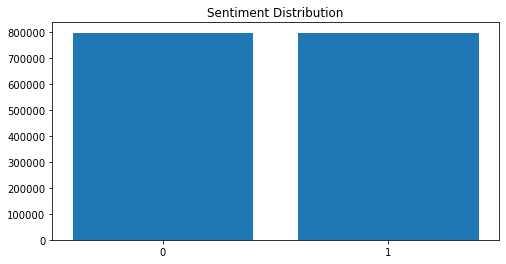

In [32]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xticks(val_count.index)
plt.title("Sentiment Distribution")

### Clean dataset: this is the pre-processing callback function used by ```TextVectorization```

## Wordcloud of ```positive``` sentiments

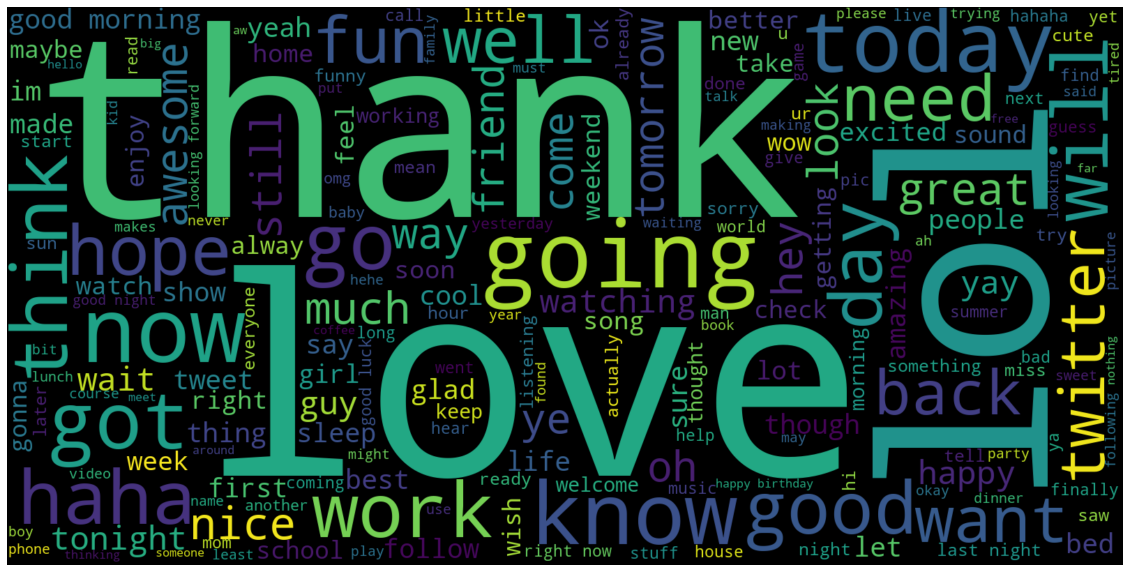

In [33]:
# add aditional stopwords
STOPWORDS.add("film")
STOPWORDS.add("movie")
STOPWORDS.add("one")
STOPWORDS.add("see")
STOPWORDS.add("make")
STOPWORDS.add("time")
STOPWORDS.add("even")
STOPWORDS.add("really")
STOPWORDS.add("character")


plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Wordcloud of ```negative``` sentiments

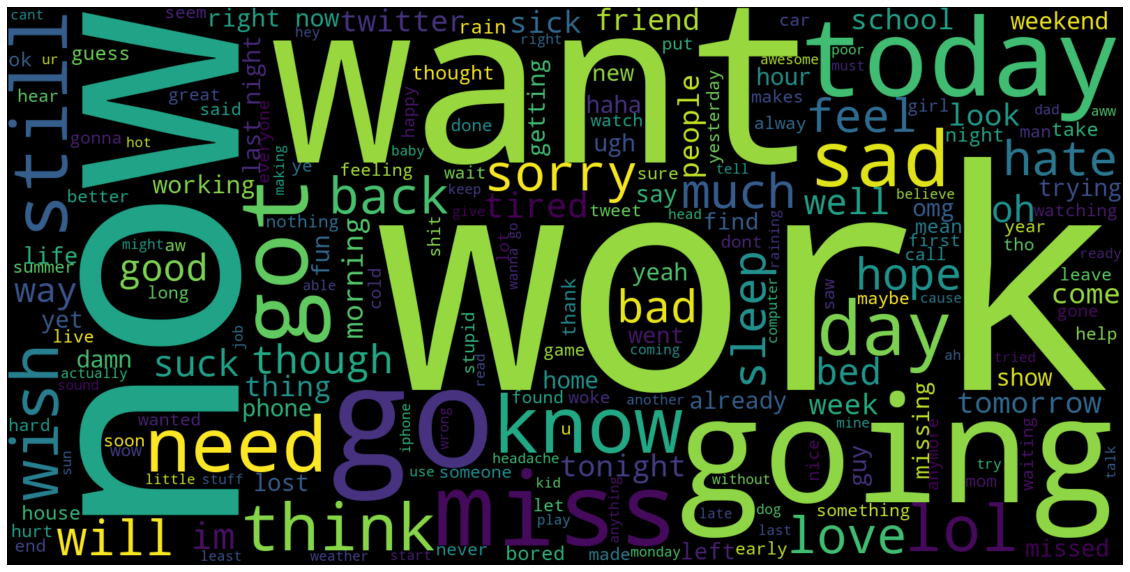

In [34]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [35]:
import string

@tf.keras.utils.register_keras_serializable(package='Custom', name='normlize_data')
def normlize_data(text):
    
    # define regex to use for replacements
    html_regex = '<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});' # remove all html tags
    url_regex = 'https?:\/\/\S+\b|www\.(\w+\.)+\S*'
    twitter_username_regex = "@\w+" # twitter username
    html_amp_start_regex = "&\w+"  # remove html entities starting with a &
    smiley_regex = "[8:=;]['`\-]?[)dD]+|[)dD]+['`\-]?[8:=;]"
    lol_face_regex = "[8:=;]['`\-]?p+"
    sad_face_regex = "[8:=;]['`\-]?\(+|\)+['`\-]?[8:=;]"
    neutral_face_regex = "[8:=;]['`\-]?[\/|l*]"
    forward_slash_regex = "/" # add space around forward slash
    heart_regex = "<3" # heart emoji
    numbers_regex = "[-+]?[.\d]*[\d]+[:,.\d]*" # remove numbers with signs e.g. -2, +3 etc..
    hash_tag_regex = "#\w+"
    repeated_punctuation_regex = "([!?.]){2,}" # e.g. replace ?????? to ?
    remove_numbers_regex = '[0-9]+' # remove all numbers
 
    # remove punctuation
    punctuation = string.punctuation
    punctuation = punctuation.translate({ord(i):None for i in "'"}) # keep the apostrophe, but remove all other punctuation
    remove_punctuation = f'[{re.escape(punctuation)}]'
    
    result = tf.strings.lower(text)
    result = tf.strings.strip(result) # remove leading and trailing spaces
     
    # make sure to remove html tags second
    result = tf.strings.regex_replace(result, html_regex, '')
     
    # remove any URLs
    result = tf.strings.regex_replace(result, url_regex, ' ') # url 
    result = tf.strings.regex_replace(result, twitter_username_regex, ' ') # twitetr user names 
    result = tf.strings.regex_replace(result, html_amp_start_regex, ' ') # any html entity that starts with an &
    result = tf.strings.regex_replace(result, smiley_regex, ' ') # remove any smilies/emojis in the text
    result = tf.strings.regex_replace(result, lol_face_regex, ' ') # lolface emoji
    result = tf.strings.regex_replace(result, sad_face_regex, ' ') # sad face emoji
    result = tf.strings.regex_replace(result, neutral_face_regex, ' ') # face emoji
    result = tf.strings.regex_replace(result, forward_slash_regex, r' / ') # add space around forward slash
    result = tf.strings.regex_replace(result, heart_regex, ' ') # remove heart emoji
    result = tf.strings.regex_replace(result, numbers_regex, ' ') # remove numbers e.g. -3, 2, 8, +8 etc..
    result = tf.strings.regex_replace(result, hash_tag_regex, ' ') # remove hashtags
    result = tf.strings.regex_replace(result, repeated_punctuation_regex, r'\1 ') # replace any repeated puctuation with single occurance
    result = tf.strings.regex_replace(result, remove_numbers_regex, ' ') # finally remove all numbers
    
    # then remove punctuation at the very end
    result = tf.strings.regex_replace(result, remove_punctuation, '')
    
    #result = tf.strings.strip(result)
    
    # print("Done!")
    return result



In [36]:
print("Training Data:\t",len(train_data), "\t\t% datapoints in train dataset:\t", math.ceil(TRAINING_SPLIT * 100),"%")
print("Test Data:\t",len(test_data), "\t\t% datapoints in test dataset:\t", math.ceil((1 - TRAINING_SPLIT) * 100) ,"%")


Training Data:	 1277800 		% datapoints in train dataset:	 80 %
Test Data:	 319451 		% datapoints in test dataset:	 20 %


## Examine the training and test data sets

### Training dataset

In [37]:
print("Number of data points: ",len(train_data))
[t for t in train_data.take(1)]

Number of data points:  1277800


[(<tf.Tensor: shape=(), dtype=string, numpy=b"it's cold out and my breakfast sandwich is hard">,
  <tf.Tensor: shape=(), dtype=int64, numpy=0>)]

### Testing dataset

In [38]:
print("Number of data points: ",len(test_data))
[t for t in test_data.take(1)]

Number of data points:  319451


[(<tf.Tensor: shape=(), dtype=string, numpy=b' i entertain others with my facebook status updates and my drunk tweets i also entertain the ladies with my charming personality'>,
  <tf.Tensor: shape=(), dtype=int64, numpy=1>)]

# Tokenization of training data
- We will use the new ```TextVectorization``` Keras class to tokenize our training data
- ```max_tokens``` i.e. limit vocabulary to this size 
- ```output_sequence_length``` i.e. limit length of text sequence

<center>
<img src="images/tokenization-manning.png">
</center>
  
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


#### We will use ```TextVectorization``` to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples.

#### 1) Our layer will only consider the top $ 50,000 $ words
#### 2) we will truncate or pad sequences to be actually $ 300 $ tokens long
#### 3) we will pre-process our text data by defining a callback function: ```normalize_data```

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 

vectorizer = TextVectorization(
    standardize=normlize_data, 
    max_tokens=50000, 
    output_mode='int',
    output_sequence_length=300)

# build vocabulary, will also run the normalize_data() function 
vectorizer.adapt(text_dataset)



## Create a dictionary, mapping words to their indices
#### Store vocabulary in a list ```vocab```, and reverse lookup in a dictionary ```word_index```

In [ ]:

vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

print("length of vocab: %d, length of word_index:  %d" % (len(vocab),len(word_index)))




### Lookup word using the vocabulary list and word_index

In [ ]:
index_of_word = word_index['movie']
print("value of index_of_word is: ",index_of_word)

word_in_vocab = vocab[index_of_word]
print("Word in vocab at index:",index_of_word, " is:", word_in_vocab)


test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

### Display the top 5 most frquent words

In [ ]:
vectorizer.get_vocabulary()[:5] # index 0 reserved for padding token and index 1 is reserved for out of vocabulary (UNK) words

### Example vectorized sentence:
#### the word ```ghjghj``` is out of vocaabulary (oov) and hence coded as 1 i.e. 'UNK'

In [ ]:

vectorizer([['the cow jumped over the moon ghjghj']]).numpy()[0, :7]


## Load pre-trained word GloVe embeddings

#### Create a dict mapping words (strings) to their NumPy vector representation

In [ ]:

embeddings_index= {}
print("Loading embeddings model to dictionary, please wait...")
with open(GLOVE_EMBEDDINGS, 'r', encoding="utf8") as f:
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Finished!")
print('Found %s word vectors in model.' %len(embeddings_index))


#### Now prepare a corresponding embedding matrix that we can use in a Keras ```Embedding``` layer

In [ ]:
num_tokens = len(vocab) + 1
embedding_dim = 300
words_found = 0
words_not_found = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
count = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        words_found += 1
    else:
        words_not_found += 1
print("Converted %d words (%d not found)" % (words_found, words_not_found))
print("Embedding matrix shape: ",  (embedding_matrix.shape))

## Build our model
#### Load our pre-trained GloVe embeddings into an ```Embedding``` layer (set ```training=False``` so to keep the embeddings fixed i.e. we do NOT want them to update during training)


In [29]:
from tensorflow.keras.layers import Embedding


def create_model(vectorizer, embedding_matrix, vocab):
    
    num_tokens = len(vocab) + 1
    embedding_dim = 300
    hits = 0
    misses = 0
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
    )
    
    
    # activation changed from tanh to relu
    # make sure to add the shape parameter (the length of the sequences), otherwise the loss and val_loss wont be calculated and will show as NaN
    inputs = keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)
    embedding_sequences = embedding_layer(x)

    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(128, dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # set dropout rate to 0.5 to prevent over-fitting
    x = Dense(512, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid')(x)
    model =  keras.Model(inputs, predictions)

    # default learning rate is 0.001 for Adam optimizer
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["acc"]
    )
    return model





# def create_model():
    
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
#     model.add(vectorizer) # use vovaculary as layer in model
#     model.add(tf.keras.layers.Embedding(num_tokens,
#                                         embedding_dim,
#                                         embeddings_initializer=keras.initializers.Constant(embedding_matrix),
#                                         trainable=False, # we don't want weights to update during training
#                                         mask_zero=True))
    
#     model.add(tf.keras.layers.SpatialDropout1D(0.2))
#     model.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
#     model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2)))
#     model.add(tf.keras.layers.Dense(512, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.5)) # set dropout rate to 0.5 to prevent over-fitting
#     model.add(tf.keras.layers.Dense(512, activation='relu'))

#     # classification layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
   

#     # default learning rate is 0.001 for Adam optimizer, reduced to 1e-4 here
#     model.compile(
#         loss="binary_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["acc"]
#     )
#     return model






## Create and compile the model, then show a summary of it

In [30]:
model = create_model(vectorizer, embedding_matrix, vocab)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          15000300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

## Train our model

#### Convert our list of strings data to a NumPy arrays of integer indices (arrays are right padded)

#### We will use ```binary_crossentropy``` since we have only two possible classifications

In [31]:
EPOCHS = 40  # for quick testing

# callbacks
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=7, 
                                         verbose=1, 
                                         min_lr = 0.0001, 
                                         mode='min')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(MODEL_BEST_WEIGHTS,
                                                         save_best_only=True,
                                                         monitor='val_acc',
                                                         save_weights_only=True,
                                                         verbose=1)


# make sure we have a GPU
print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")

model_history = model.fit(train_data.batch(BATCH_SIZE), epochs=EPOCHS, validation_data=test_data.batch(BATCH_SIZE),callbacks=[reduce_lr_on_plateau,checkpoint_callback] )



Training on GPU...
Epoch 1/40
625/625 [==============================] - ETA: 0s - loss: 0.5487 - acc: 0.7172
Epoch 00001: val_acc improved from -inf to 0.82770, saving model to ../models/imdb/imdb_sentiment/0001/assets/cp.ckpt
625/625 [==============================] - 41s 66ms/step - loss: 0.5487 - acc: 0.7172 - val_loss: 0.4119 - val_acc: 0.8277
Epoch 2/40
625/625 [==============================] - ETA: 0s - loss: 0.4335 - acc: 0.8077
Epoch 00002: val_acc improved from 0.82770 to 0.83920, saving model to ../models/imdb/imdb_sentiment/0001/assets/cp.ckpt
625/625 [==============================] - 40s 65ms/step - loss: 0.4335 - acc: 0.8077 - val_loss: 0.3641 - val_acc: 0.8392
Epoch 3/40
625/625 [==============================] - ETA: 0s - loss: 0.3923 - acc: 0.8290
Epoch 00003: val_acc improved from 0.83920 to 0.85880, saving model to ../models/imdb/imdb_sentiment/0001/assets/cp.ckpt
625/625 [==============================] - 40s 65ms/step - loss: 0.3923 - acc: 0.8290 - val_loss: 0.33

## Evaluate model using unseen test data

In [32]:

scores_evaluate = model.evaluate(test_data.batch(BATCH_SIZE),verbose=1)
print("Accuracy: %.2f%%" % (scores_evaluate[1]*100))


157/157 [==============================] - 5s 30ms/step - loss: 0.3286 - acc: 0.8849
Accuracy: 88.49%


### Plot confusion matrix

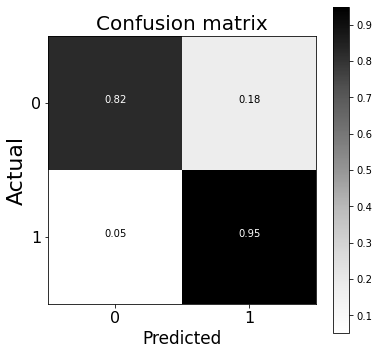



               precision    recall  f1-score   support

           0       0.94      0.82      0.88      4993
           1       0.84      0.95      0.89      5007

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [33]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys, normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)
    
    
def decode_sentiment(score):
    return 1 if score>0.5 else 0

scores_predict = model.predict(test_data.batch(BATCH_SIZE),verbose=0)
y_predictions = [decode_sentiment(score) for score in scores_predict]

# add text predictions to list 
text_dataset_predictions = []
[text_dataset_predictions.append(item[1].numpy()) for item in test_data]



cnf_matrix = confusion_matrix(text_dataset_predictions, y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=list(set(text_dataset_predictions)), title="Confusion matrix")
plt.savefig('images/imdb-confusion-matrix.png',bbox_inches='tight')
plt.show()

# show the summary report
print("\n\n",classification_report(text_dataset_predictions, y_predictions))

### Test the model

In [35]:
# check negative review
p = [["Totally overrated serie, the storyline just doesn't add up. Especially the action scenes are chaotic, have no common sense. The only positive thing is the acting of the Mandalorian. The little gremlin (baby Yoda) is only cute, but it uses his (or her?) powers on strange moments. Overall not worth to pay for Disney+ only for this serie."]]
prob_positive = model.predict(p)
print("Probability this review is positive: ",prob_positive)


# check positive review
p = [["This is the Star Wars atmosphere and feeling I've been waiting for. No dumb humor, cool characters, and a story I can take seriously. I'm a big fan of what they've done with this series so far and current Star Wars filmmakers need to take notes. The cinematography is amazing. You can tell they use practicality as much as possible and CGI is used only for the obvious like spaceships and creatures etc. It's a truly remarkable balance of old and new."]]
prob_positive = model.predict(p)
print("Probability this review is positive: ",prob_positive)

Probability this review is positive:  [[0.1174846]]
Probability this review is positive:  [[0.83070904]]


## Load the best weights generated

In [36]:

model.load_weights(MODEL_BEST_WEIGHTS) # loads best weights saved during training

scores_evaluate = model.evaluate(test_data.batch(BATCH_SIZE),verbose=1)
print("Accuracy: %.2f%%" % (scores_evaluate[1]*100))

157/157 [==============================] - 5s 30ms/step - loss: 0.2530 - acc: 0.8993
Accuracy: 89.93%


### Check model again after loading the best weights found for the model

In [39]:
# check negative review
p_2 = [["Totally overrated serie, the storyline just doesn't add up. Especially the action scenes are chaotic, have no common sense. The only positive thing is the acting of the Mandalorian. The little gremlin (baby Yoda) is only cute, but it uses his (or her?) powers on strange moments. Overall not worth to pay for Disney+ only for this serie."]]
prob_positive = model.predict(p_2)
print("Probability this review is positive: ",prob_positive)


# check positive review
p = [["This is the Star Wars atmosphere and feeling I've been waiting for. No dumb humor, cool characters, and a story I can take seriously. I'm a big fan of what they've done with this series so far and current Star Wars filmmakers need to take notes. The cinematography is amazing. You can tell they use practicality as much as possible and CGI is used only for the obvious like spaceships and creatures etc. It's a truly remarkable balance of old and new."]]
prob_positive = model.predict(p)
print("Probability this review is positive: ",prob_positive)

Probability this review is positive:  [[0.13463074]]
Probability this review is positive:  [[0.96699154]]


## Save our final model, along with the embedding_matrix and vocab file, so we can recreate it exactly


In [40]:
from keras.models import load_model

# save the model first, so that assets folder is created and available
model.save(MODEL_PATH)  # creates a .pd file

# save history as a dictionary in case we need to recreate the plots again later
with open(MODEL_TRAINING_HISORTY_FILE, 'wb') as file_pickle:
        pickle.dump(model_history.history, file_pickle)


# save the vocabulary file
with open(MODEL_ASSETS_VOCABULARY_FILE, 'wb') as file_pickle:
        pickle.dump(vocab, file_pickle)


# save the embeddings matrix
with open(MODEL_ASSETS_EMBEDDINGS_FILE, 'wb') as file_pickle:
        pickle.dump(embedding_matrix, file_pickle)




INFO:tensorflow:Assets written to: ../models/imdb/imdb_sentiment/0001/assets


## Reload saved model

In [42]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # in Tensorflow 2.1 and above
import pickle 

v = pickle.load(open(MODEL_ASSETS_VOCABULARY_FILE, 'rb'))
em = pickle.load(open(MODEL_ASSETS_EMBEDDINGS_FILE, 'rb'))


vectorizer_layer = TextVectorization(
    standardize=normlize_data, 
    max_tokens=50000, 
    output_mode='int',
    output_sequence_length=300)

# build vocabulary, will also run the normalize_data() 
vectorizer_layer.set_vocabulary(v)


saved_model = create_model(vectorizer_layer,em,v)

# load the weights
saved_model.load_weights(MODEL_BEST_WEIGHTS) # loads best weights saved during training

## Check predictions for the above input is the same

In [43]:
# check negative review
p_2 = [["Totally overrated serie, the storyline just doesn't add up. Especially the action scenes are chaotic, have no common sense. The only positive thing is the acting of the Mandalorian. The little gremlin (baby Yoda) is only cute, but it uses his (or her?) powers on strange moments. Overall not worth to pay for Disney+ only for this serie."]]
prob_positive = saved_model.predict(p_2)
print("Probability this review is positive: ",prob_positive)


# check positive review
p = [["This is the Star Wars atmosphere and feeling I've been waiting for. No dumb humor, cool characters, and a story I can take seriously. I'm a big fan of what they've done with this series so far and current Star Wars filmmakers need to take notes. The cinematography is amazing. You can tell they use practicality as much as possible and CGI is used only for the obvious like spaceships and creatures etc. It's a truly remarkable balance of old and new."]]
prob_positive = saved_model.predict(p)
print("Probability this review is positive: ",prob_positive)

Probability this review is positive:  [[0.13463074]]
Probability this review is positive:  [[0.96699154]]


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [ ]:

counter_embeddings_matrix = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)


### Shape of our vocabulary matrix

In [ ]:

print(counter_embeddings_matrix.shape)


### Save our vocabulary embeddings matrix

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, loss,'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/S140-training-and-validation-loss.png',bbox_inches='tight')
plt.show()


In [ ]:
plt.clf()   # clear figure
plt.figure(figsize=(12,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/S140-training-and-validation-accuracy.png',bbox_inches='tight')
plt.show()


In [ ]:
counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)
#counter_dict = counter_embeddings_dictionary(COUNTER_FITTED_VECTORS)

In [ ]:
import numpy as np
counter_embeddings_matrix = np.load(("embeddings/imdb_counter_fitted_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))
#print(find_closest_embeddings(data_dictionary["movies"])[1:10])


print(type(counter_embeddings_matrix))
print(counter_embeddings_matrix.shape)

# Generate and save word distance matrix
#### l2 distance: $(x-y)^2$ expand this out and we get: $x^2 + y^2 - 2xy$ using this to calculate euclidian (l2) distance between vectors



In [ ]:
def distance_matrix(matrix):
    dists = -2 * np.dot(matrix, matrix.T) + np.sum(matrix**2,    axis=1) + np.sum(matrix**2, axis=1)[:, np.newaxis]
    return dists

In [ ]:
"""
THIS IS WHY WE HAVE TO REDUCE THE VOCABULARY SIZE - WE NEED TO ALLOCATE ENOUGH SPACE FOR THIS MATRIX
IF WE USE THE FULL VOCABULARY SIZE - WE WILL NOT BE ABLE TO ALLOCATE ENOUGH MEMORY FOR THE SIZE OF THE MATRIX
THAT WILL BE GENERATED
"""
square_matrix = -2 * np.dot(counter_embeddings_matrix, counter_embeddings_matrix.T)
print(len(square_matrix))

In [ ]:
a = np.sum(np.square(counter_embeddings_matrix), axis=1).reshape((1,-1))

In [ ]:
b = a.T

In [ ]:
square_matrix.shape

In [ ]:
a.shape

In [ ]:
b.shape

# Save the distance matrix

In [ ]:
dist = a + b + square_matrix

In [ ]:
np.save(('embeddings/distance_counterfitted_embeddings_%d.npy' % MAX_VOCABULARY_SIZE), dist)

In [ ]:
np.amax(dist)

In [ ]:
np.amin(dist)

# Closest words in disrtance matrix, and their distances

In [ ]:
from manny_train import build_embeddings as bemb

for r in range(100,105):
    source_word = r
    
    nearest_neighbour, distance_to_neighbour = bemb.closest_neighbours(source_word, dist, ret_count=5)
    
    print("Nearest Neighbours to `%s` are:" %inv_data_dictionary[source_word])
    
    for word_index, distance in zip(nearest_neighbour,distance_to_neighbour):
        print("\t--> ", inv_data_dictionary[word_index], "     ", distance)
    print("----------------------------------------------------------------\n")



In [ ]:
dist_order = np.argsort(dist[src_word, :])[1:8]
print(dist_order)

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds


In [ ]:
tf.__version__

In [ ]:
# Load the IMDB reviews dataset using tfds. This is the raw data.
imdb_reviews = tfds.load('imdb_reviews')

# The IMDB dataset contains a train split and a test split; we create a separate
# handle for each.
train_raw = imdb_reviews['train']
test_raw = imdb_reviews['test']


# Once we have our handles, we format the datasets in a Keras-fit compatible
# format: a tuple of the form (text_data, label).
def format_dataset(input_data):
    return (input_data['text'], input_data['label'])

train_dataset = train_raw.map(format_dataset)
test_dataset = test_raw.map(format_dataset)

# We also create a dataset with only the textual data in it. This will be used
# to build our vocabulary later on.

text_dataset_1 = train_raw.map(lambda data: data['text'])



In [ ]:
for t, i in train_dataset.take(1):
    print(t)